<a href="https://colab.research.google.com/github/armandomacri/Skin-Lesion-CNN/blob/main/C_Pre_trained_ResNet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solve the problem leveraging ResNet-50 architecture
In this notebook, we will use the ResNet-50 architecture for our classification problem.

First, we'll try a simple **feature extraction**. Since the architecture was trained on a different dataset, we do not expect very good performance, but we can use these results as a baseline for the next step: **fine-tuning**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%run "drive/Shareddrives/CIDL Project/Macrì,Tortora/Utilities.ipynb"

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
# this jupyter extension will print out the running time of cell executions
!pip install -q ipython-autotime
%load_ext autotime

time: 191 µs (started: 2022-05-10 07:39:56 +00:00)


In [ ]:
!pip install -U tensorflow-addons

time: 4.77 s (started: 2022-05-10 07:39:57 +00:00)


##Import Libraries

In [ ]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.layers import Dense, Flatten
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

set_seed()

time: 41.1 ms (started: 2022-05-10 07:40:01 +00:00)


## Load dataset from Google Drive
The dataset is stored in Google Drive in a zip file, we unzip it locally for better performance.

In [ ]:
#load traing set
!unzip -q "/content/drive/Shareddrives/CIDL Project/data/trainingSet.zip" -d "/content"

time: 23.4 s (started: 2022-05-10 07:40:01 +00:00)


In [ ]:
#load validation set
!unzip -q "/content/drive/Shareddrives/CIDL Project/data/validationSet.zip" -d "/content"

time: 3.54 s (started: 2022-05-10 07:40:25 +00:00)


In [ ]:
#load test set
!unzip -q "/content/drive/Shareddrives/CIDL Project/data/testSet.zip" -d "/content"

time: 3.66 s (started: 2022-05-10 07:40:28 +00:00)


###Prepare the datasets

In [ ]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

time: 3.82 ms (started: 2022-05-10 07:40:32 +00:00)


Compute class wheights


In [ ]:
class_weights = compute_class_weights()
class_weights

{0: 1.2004132231404958,
 1: 13.35632183908046,
 2: 0.9923142613151152,
 3: 3.8223684210526314,
 4: 0.24210855297426814,
 5: 12.911111111111111,
 6: 0.7046694966646453,
 7: 5.107692307692307}

time: 44.6 ms (started: 2022-05-10 07:40:32 +00:00)


In [ ]:
training_dir = PATH = 'trainingSet'
validation_dir = 'validationSet'
test_dir = "testSet"

training_dataset = tf.keras.utils.image_dataset_from_directory(
                      training_dir,
                      label_mode="categorical",
                      labels="inferred",
                      shuffle=True,
                      image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                      batch_size=BATCH_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
                      validation_dir,
                      label_mode="categorical",
                      labels="inferred",
                      shuffle=True,
                      image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                      batch_size=BATCH_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(
                      test_dir,
                      label_mode="categorical",
                      labels="inferred",
                      shuffle=False,
                      image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                      batch_size=BATCH_SIZE)

Found 18592 files belonging to 8 classes.
Found 2069 files belonging to 8 classes.
Found 1867 files belonging to 8 classes.
time: 5.48 s (started: 2022-05-10 07:40:32 +00:00)


##4.2 Load the pre-trained ResNet-50

In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import regularizers
import pathlib
import matplotlib.pyplot as plt
import numpy as np

time: 4.3 ms (started: 2022-05-10 07:40:38 +00:00)


In [ ]:
#@markdown  Download the pre-trained ResNet-50 with weights obtained from training on the [Imagenet](http://image-net.org/index) dataset
#load the pre-trained Network, weights obtained from training on ImageNet dataset
#@markdown To classify lesions among the 8 classes, we need to substitute the final layers (fc1000) of the ResNet-50 to reduce the number of ouputs from 1000 to 8.
# The new fully connected layer will have a number of classes equal to Train_data.num_classes (8)

conv_base = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
)
conv_base.trainable = False

94781440/94765736 [==============================] - 1s 0us/step
time: 2.74 s (started: 2022-05-10 07:40:38 +00:00)


In [ ]:
data_augmentation = keras.Sequential(
  [
  layers.RandomFlip("vertical"),
  layers.RandomFlip("horizontal"),
  layers.RandomZoom(0.1, fill_mode="constant", fill_value=0.0),
  layers.RandomRotation(factor=1, fill_mode="constant", fill_value=0.0),
  ]
)

time: 10.9 ms (started: 2022-05-10 07:40:40 +00:00)


###Experiment 1: one dense layer with 64 neurons

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
#inputs = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu') (x)
outputs = layers.Dense(8, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)

time: 550 ms (started: 2022-05-10 07:40:40 +00:00)


In [ ]:
print(model1.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                             

In [ ]:
model1 = compile_model(model1)

time: 20.5 ms (started: 2022-05-10 07:40:41 +00:00)


In [ ]:
history1 = run_model(model1, 'ResNet50_experiment1', training_dataset, validation_dataset, class_weights)

Training:   0%|           0/30 ETA: ?s,  ?epochs/s

Epoch 1/30


0/581           ETA: ?s - 

Epoch 1/30
581/581 [==============================] - ETA: 0s - loss: 3.3543 - accuracy: 0.5978
Epoch 1: val_loss improved from inf to 1.73213, saving model to /content/drive/Shareddrives/CIDL Project/Macrì,Tortora/models/ResNet50_experiment1.h5
581/581 [==============================] - 541s 910ms/step - loss: 3.3543 - accuracy: 0.5978 - val_loss: 1.7321 - val_accuracy: 0.5993
Epoch 2/30


0/581           ETA: ?s - 

Epoch 2/30
581/581 [==============================] - ETA: 0s - loss: 1.9282 - accuracy: 0.6383
Epoch 2: val_loss improved from 1.73213 to 1.68142, saving model to /content/drive/Shareddrives/CIDL Project/Macrì,Tortora/models/ResNet50_experiment1.h5
581/581 [==============================] - 527s 906ms/step - loss: 1.9282 - accuracy: 0.6383 - val_loss: 1.6814 - val_accuracy: 0.6230
Epoch 3/30


0/581           ETA: ?s - 

Epoch 3/30
581/581 [==============================] - ETA: 0s - loss: 1.3731 - accuracy: 0.6766
Epoch 3: val_loss did not improve from 1.68142
581/581 [==============================] - 525s 903ms/step - loss: 1.3731 - accuracy: 0.6766 - val_loss: 1.7197 - val_accuracy: 0.6370
Epoch 4/30


0/581           ETA: ?s - 

Epoch 4/30
581/581 [==============================] - ETA: 0s - loss: 1.0230 - accuracy: 0.7051
Epoch 4: val_loss improved from 1.68142 to 1.46818, saving model to /content/drive/Shareddrives/CIDL Project/Macrì,Tortora/models/ResNet50_experiment1.h5
581/581 [==============================] - 527s 907ms/step - loss: 1.0230 - accuracy: 0.7051 - val_loss: 1.4682 - val_accuracy: 0.6433
Epoch 5/30


0/581           ETA: ?s - 

Epoch 5/30
581/581 [==============================] - ETA: 0s - loss: 0.8093 - accuracy: 0.7367
Epoch 5: val_loss did not improve from 1.46818
581/581 [==============================] - 524s 902ms/step - loss: 0.8093 - accuracy: 0.7367 - val_loss: 1.4779 - val_accuracy: 0.6631
Epoch 6/30


0/581           ETA: ?s - 

Epoch 6/30
581/581 [==============================] - ETA: 0s - loss: 0.6432 - accuracy: 0.7683
Epoch 6: val_loss improved from 1.46818 to 1.46769, saving model to /content/drive/Shareddrives/CIDL Project/Macrì,Tortora/models/ResNet50_experiment1.h5
581/581 [==============================] - 527s 906ms/step - loss: 0.6432 - accuracy: 0.7683 - val_loss: 1.4677 - val_accuracy: 0.6694
Epoch 7/30


0/581           ETA: ?s - 

Epoch 7/30
581/581 [==============================] - ETA: 0s - loss: 0.5461 - accuracy: 0.7879
Epoch 7: val_loss did not improve from 1.46769
581/581 [==============================] - 525s 902ms/step - loss: 0.5461 - accuracy: 0.7879 - val_loss: 1.6757 - val_accuracy: 0.6723
Epoch 8/30


0/581           ETA: ?s - 

Epoch 8/30
581/581 [==============================] - ETA: 0s - loss: 0.4097 - accuracy: 0.8181
Epoch 8: val_loss did not improve from 1.46769
581/581 [==============================] - 524s 902ms/step - loss: 0.4097 - accuracy: 0.8181 - val_loss: 1.4708 - val_accuracy: 0.6839
Epoch 9/30


0/581           ETA: ?s - 

Epoch 9/30
581/581 [==============================] - ETA: 0s - loss: 0.3376 - accuracy: 0.8379
Epoch 9: val_loss improved from 1.46769 to 1.40385, saving model to /content/drive/Shareddrives/CIDL Project/Macrì,Tortora/models/ResNet50_experiment1.h5
581/581 [==============================] - 527s 905ms/step - loss: 0.3376 - accuracy: 0.8379 - val_loss: 1.4039 - val_accuracy: 0.6907
Epoch 10/30


0/581           ETA: ?s - 

Epoch 10/30
581/581 [==============================] - ETA: 0s - loss: 0.2626 - accuracy: 0.8606
Epoch 10: val_loss improved from 1.40385 to 1.34951, saving model to /content/drive/Shareddrives/CIDL Project/Macrì,Tortora/models/ResNet50_experiment1.h5
581/581 [==============================] - 527s 906ms/step - loss: 0.2626 - accuracy: 0.8606 - val_loss: 1.3495 - val_accuracy: 0.6989
Epoch 11/30


0/581           ETA: ?s - 

Epoch 11/30
581/581 [==============================] - ETA: 0s - loss: 0.2441 - accuracy: 0.8655
Epoch 11: val_loss improved from 1.34951 to 1.30314, saving model to /content/drive/Shareddrives/CIDL Project/Macrì,Tortora/models/ResNet50_experiment1.h5
581/581 [==============================] - 527s 906ms/step - loss: 0.2441 - accuracy: 0.8655 - val_loss: 1.3031 - val_accuracy: 0.6916
Epoch 12/30


0/581           ETA: ?s - 

Epoch 12/30
581/581 [==============================] - ETA: 0s - loss: 0.5611 - accuracy: 0.8145
Epoch 12: val_loss did not improve from 1.30314
581/581 [==============================] - 526s 905ms/step - loss: 0.5611 - accuracy: 0.8145 - val_loss: 1.5619 - val_accuracy: 0.6781
Epoch 13/30


0/581           ETA: ?s - 

Epoch 13/30
581/581 [==============================] - ETA: 0s - loss: 0.3209 - accuracy: 0.8468
Epoch 13: val_loss did not improve from 1.30314
581/581 [==============================] - 525s 902ms/step - loss: 0.3209 - accuracy: 0.8468 - val_loss: 1.4750 - val_accuracy: 0.6713
Epoch 14/30


0/581           ETA: ?s - 

Epoch 14/30
581/581 [==============================] - ETA: 0s - loss: 0.1903 - accuracy: 0.8774
Epoch 14: val_loss did not improve from 1.30314
581/581 [==============================] - 524s 902ms/step - loss: 0.1903 - accuracy: 0.8774 - val_loss: 1.4605 - val_accuracy: 0.6820
Epoch 15/30


0/581           ETA: ?s - 

Epoch 15/30
581/581 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.8996
Epoch 15: val_loss did not improve from 1.30314
581/581 [==============================] - 525s 903ms/step - loss: 0.1280 - accuracy: 0.8996 - val_loss: 1.4078 - val_accuracy: 0.6926
Epoch 16/30


0/581           ETA: ?s - 

Epoch 16/30
581/581 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.9132
Epoch 16: val_loss did not improve from 1.30314
581/581 [==============================] - 527s 906ms/step - loss: 0.1001 - accuracy: 0.9132 - val_loss: 1.3906 - val_accuracy: 0.6912
Epoch 16: early stopping
time: 2h 26min 17s (started: 2022-05-10 07:40:41 +00:00)


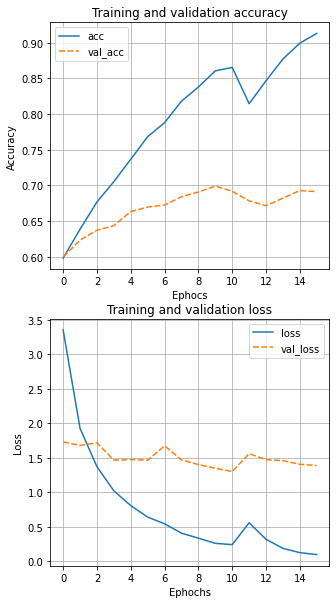

time: 538 ms (started: 2022-05-10 10:07:55 +00:00)


In [ ]:
plot_model_performance(history1)

###Esperimento da sistemare

In [ ]:


inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
inputs = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu') (x)
x = layers.Dense(128, activation='relu') (x)
x = layers.Dense(64, activation='relu') (x)
outputs = layers.Dense(8, activation='softmax', name = 'predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

94781440/94765736 [==============================] - 2s 0us/step
time: 4.99 s (started: 2022-05-09 14:10:44 +00:00)


In [ ]:
#@title 4.3 Visualize the final architecture
#@markdown Notice the change of number of classes of the last dense layer.
# this is the final architecture
#model = Model(inputs=model_ResNet50.input, outputs=predict)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                             

In [ ]:
model = compile_model(model)

time: 27.3 ms (started: 2022-05-09 14:11:01 +00:00)


In [ ]:
history = run_model(model, 'ResNet50', training_dataset, validation_dataset, class_weights)

Training:   0%|           0/30 ETA: ?s,  ?epochs/s

Epoch 1/30


0/581           ETA: ?s - 

Epoch 1/30
581/581 [==============================] - ETA: 0s - loss: 2.3482 - accuracy: 0.4557
Epoch 1: val_loss improved from inf to 1.27376, saving model to /content/drive/Shareddrives/CIDL Project/Macrì,Tortora/models/ResNet50.h5
581/581 [==============================] - 442s 738ms/step - loss: 2.3482 - accuracy: 0.4557 - val_loss: 1.2738 - val_accuracy: 0.5781
Epoch 2/30


0/581           ETA: ?s - 

Epoch 2/30
581/581 [==============================] - ETA: 0s - loss: 1.3142 - accuracy: 0.5958
Epoch 2: val_loss improved from 1.27376 to 1.03474, saving model to /content/drive/Shareddrives/CIDL Project/Macrì,Tortora/models/ResNet50.h5
581/581 [==============================] - 432s 741ms/step - loss: 1.3142 - accuracy: 0.5958 - val_loss: 1.0347 - val_accuracy: 0.6409
Epoch 3/30


0/581           ETA: ?s - 

Epoch 3/30
581/581 [==============================] - ETA: 0s - loss: 0.8470 - accuracy: 0.6767
Epoch 3: val_loss improved from 1.03474 to 0.99672, saving model to /content/drive/Shareddrives/CIDL Project/Macrì,Tortora/models/ResNet50.h5
581/581 [==============================] - 431s 741ms/step - loss: 0.8470 - accuracy: 0.6767 - val_loss: 0.9967 - val_accuracy: 0.6655
Epoch 4/30


0/581           ETA: ?s - 

Epoch 4/30
581/581 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.7370
Epoch 4: val_loss did not improve from 0.99672
581/581 [==============================] - 423s 727ms/step - loss: 0.6105 - accuracy: 0.7370 - val_loss: 1.1504 - val_accuracy: 0.6177
Epoch 5/30


0/581           ETA: ?s - 

Epoch 5/30
581/581 [==============================] - ETA: 0s - loss: 0.4357 - accuracy: 0.7916
Epoch 5: val_loss did not improve from 0.99672
581/581 [==============================] - 424s 728ms/step - loss: 0.4357 - accuracy: 0.7916 - val_loss: 1.0882 - val_accuracy: 0.6472
Epoch 6/30


0/581           ETA: ?s - 

Epoch 6/30
581/581 [==============================] - ETA: 0s - loss: 0.2981 - accuracy: 0.8449
Epoch 6: val_loss did not improve from 0.99672
581/581 [==============================] - 423s 726ms/step - loss: 0.2981 - accuracy: 0.8449 - val_loss: 1.1141 - val_accuracy: 0.6713
Epoch 7/30


0/581           ETA: ?s - 

Epoch 7/30
581/581 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.8316
Epoch 7: val_loss did not improve from 0.99672
581/581 [==============================] - 425s 730ms/step - loss: 0.3805 - accuracy: 0.8316 - val_loss: 1.0277 - val_accuracy: 0.7013
Epoch 8/30


0/581           ETA: ?s - 

Epoch 8/30
581/581 [==============================] - ETA: 0s - loss: 0.2793 - accuracy: 0.8618
Epoch 8: val_loss did not improve from 0.99672
581/581 [==============================] - 425s 730ms/step - loss: 0.2793 - accuracy: 0.8618 - val_loss: 1.0467 - val_accuracy: 0.7095
Epoch 8: early stopping
time: 58min (started: 2022-05-09 14:12:55 +00:00)


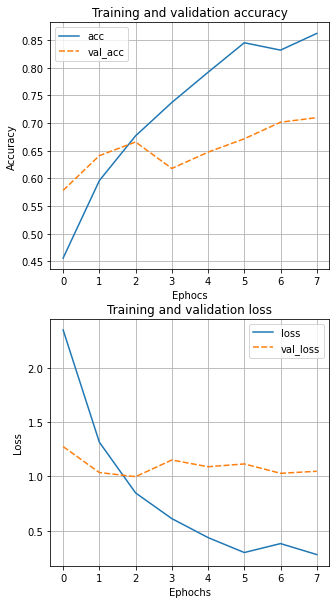

time: 539 ms (started: 2022-05-09 15:18:42 +00:00)


In [ ]:
plot_model_performance(history)

###Experiment 2

#Provare RMSPRop come optimizer